In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/"
RES_DIR = ROOT_DIR + "resources/"
MOD_DIR = ROOT_DIR + "ml_models/"
BATCH_SIZE = 16

X = pd.read_csv(RES_DIR + "X_POS4.csv")["Sysnet"]
y = pd.read_csv(RES_DIR + "y_POS4.csv")["POS"]


In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128
vocab_size = 25000  # Only consider the top 20k words
maxlen = 100  # Only consider the first 200 words of each movie review


In [4]:
X_pom, X_val, y_pom, y_val = train_test_split(X, y, test_size=.1, stratify=y, )
X_train, X_test, y_train, y_test = train_test_split(X_pom, y_pom, test_size=.2, stratify=y_pom, )

X_val = tf.convert_to_tensor(X_val, name ="Definicija")
y_val = tf.convert_to_tensor(y_val, name ="Sentiment")


X_train = tf.convert_to_tensor(X_train, name ="Definicija")
y_train = tf.convert_to_tensor(y_train, name ="Sentiment")

X_test = tf.convert_to_tensor(X_test, name ="Definicija")
y_test = tf.convert_to_tensor(y_test, name ="Sentiment")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [7]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [8]:
VOCAB_SIZE = 25000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode="int" )
encoder.adapt(train_dataset.map(lambda text, label: text))



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(1,), dtype=tf.string)
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = encoder(inputs)
x = embedding_layer(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
#activation="softmax"
model_POS = keras.Model(inputs=inputs, outputs=outputs)

## Train and Evaluate

In [10]:
model_POS.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["binary_accuracy"]
)
history = model_POS.fit(train_dataset, epochs=15,
                    validation_data=validation_dataset,
                    validation_steps=15)

Epoch 1/15
113/113 [==============================] - 23s 165ms/step - loss: 0.0827 - binary_accuracy: 0.9855 - val_loss: 0.0749 - val_binary_accuracy: 0.9854
Epoch 2/15
113/113 [==============================] - 18s 161ms/step - loss: 0.0681 - binary_accuracy: 0.9855 - val_loss: 0.0820 - val_binary_accuracy: 0.9854
Epoch 3/15
113/113 [==============================] - 19s 169ms/step - loss: 0.0415 - binary_accuracy: 0.9859 - val_loss: 0.0804 - val_binary_accuracy: 0.9844
Epoch 4/15
113/113 [==============================] - 18s 157ms/step - loss: 0.0188 - binary_accuracy: 0.9920 - val_loss: 0.0834 - val_binary_accuracy: 0.9734
Epoch 5/15
113/113 [==============================] - 17s 155ms/step - loss: 0.0127 - binary_accuracy: 0.9950 - val_loss: 0.0872 - val_binary_accuracy: 0.9833
Epoch 6/15
113/113 [==============================] - 18s 160ms/step - loss: 0.0094 - binary_accuracy: 0.9963 - val_loss: 0.1083 - val_binary_accuracy: 0.9818
Epoch 7/15
113/113 [==========================

In [11]:
model_POS.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 token_and_position_embeddin  (None, None, 64)         1606400   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, None, 64)         74944     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 64)               0     

In [12]:
y_proba = model_POS.predict(X_test)
y_classes = tf.round((y_proba))
#y_classes = tf.round(tf.nn.sigmoid(y_proba))

114/114 [==============================] - 1s 10ms/step


In [13]:
y_classes[5:]

<tf.Tensor: shape=(3612, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [14]:
y_proba[5:]

array([[4.9444486e-07],
       [6.9011747e-07],
       [5.1414429e-07],
       ...,
       [5.4916649e-07],
       [5.9281001e-07],
       [1.1702246e-06]], dtype=float32)

In [15]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_classes).numpy()


In [16]:
con_mat

array([[3540,   25],
       [  36,   16]], dtype=int32)

In [17]:
from keras.utils.vis_utils import plot_model

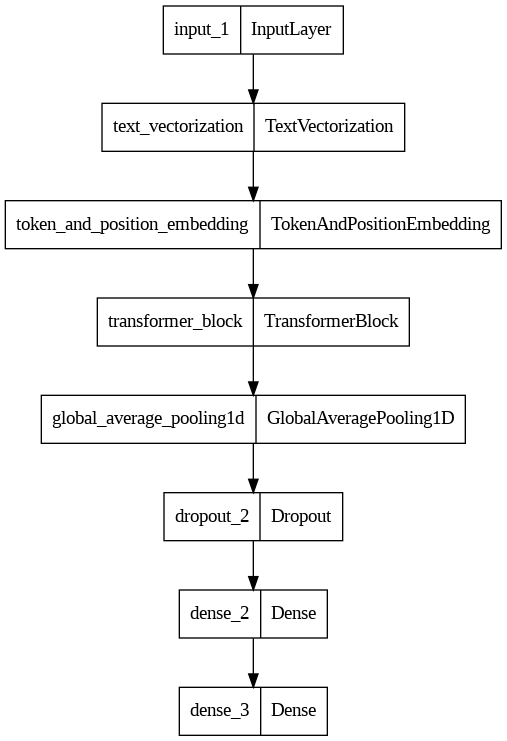

In [18]:
plot_model(model_POS)

In [19]:
def polarity_correction(pos, neg):
  one = tf.convert_to_tensor(1.0)
  ret_pos = pos*(one - neg)
  ret_neg =neg * (one -pos)
  return ret_pos, ret_neg
  

In [20]:
X = pd.read_csv(RES_DIR + "X_NEG4.csv")["Sysnet"]
y = pd.read_csv(RES_DIR + "y_NEG4.csv")["NEG"]

In [21]:
X_pom, X_val, y_pom, y_val = train_test_split(X, y, test_size=.1, stratify=y, )
X_train, X_test, y_train, y_test = train_test_split(X_pom, y_pom, test_size=.2, stratify=y_pom, )

X_val = tf.convert_to_tensor(X_val, name ="Definicija")
y_val = tf.convert_to_tensor(y_val, name ="Sentiment")


X_train = tf.convert_to_tensor(X_train, name ="Definicija")
y_train = tf.convert_to_tensor(y_train, name ="Sentiment")

X_test = tf.convert_to_tensor(X_test, name ="Definicija")
y_test = tf.convert_to_tensor(y_test, name ="Sentiment")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [22]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [23]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode="int" )
encoder.adapt(train_dataset.map(lambda text, label: text))



In [24]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(1,), dtype=tf.string)
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = encoder(inputs)
x = embedding_layer(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
#activation="softmax"
model_NEG = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model_NEG.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["binary_accuracy"]
)
history = model_NEG.fit(train_dataset, epochs=15,
                    validation_data=validation_dataset,
                    validation_steps=15)

Epoch 1/15
113/113 [==============================] - 23s 176ms/step - loss: 0.0940 - binary_accuracy: 0.9780 - val_loss: 0.0851 - val_binary_accuracy: 0.9833
Epoch 2/15
113/113 [==============================] - 18s 161ms/step - loss: 0.0779 - binary_accuracy: 0.9838 - val_loss: 0.0726 - val_binary_accuracy: 0.9833
Epoch 3/15
113/113 [==============================] - 18s 161ms/step - loss: 0.0487 - binary_accuracy: 0.9856 - val_loss: 0.0742 - val_binary_accuracy: 0.9823
Epoch 4/15
113/113 [==============================] - 18s 158ms/step - loss: 0.0192 - binary_accuracy: 0.9920 - val_loss: 0.1006 - val_binary_accuracy: 0.9729
Epoch 5/15
113/113 [==============================] - 18s 163ms/step - loss: 0.0099 - binary_accuracy: 0.9963 - val_loss: 0.1067 - val_binary_accuracy: 0.9812
Epoch 6/15
113/113 [==============================] - 18s 157ms/step - loss: 0.0078 - binary_accuracy: 0.9972 - val_loss: 0.1065 - val_binary_accuracy: 0.9802
Epoch 7/15
113/113 [==========================

In [26]:
y_proba = model_POS.predict(X_test)
y_classes = tf.round((y_proba))
#y_classes = tf.round(tf.nn.sigmoid(y_proba))

114/114 [==============================] - 1s 9ms/step


In [27]:
y_classes[5:]

<tf.Tensor: shape=(3612, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [28]:
y_proba[5:]

array([[8.3419837e-07],
       [7.0317606e-07],
       [6.4900263e-07],
       ...,
       [1.1195161e-06],
       [5.5845391e-07],
       [8.1787164e-07]], dtype=float32)

In [29]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_classes).numpy()


In [30]:
con_mat

array([[3511,   48],
       [  53,    5]], dtype=int32)

In [31]:
sword = pd.read_csv(RES_DIR +"definicije_lematizone.csv", index_col=0)

In [32]:
definicije = sword["Definicija"]

In [33]:
tensor_def = tf.convert_to_tensor(definicije.to_numpy(dtype='str'))

In [34]:
tn_POS = model_POS.predict(tensor_def)
tn_NEG = model_NEG.predict(tensor_def)


792/792 [==============================] - 7s 9ms/step


In [35]:
tn_POSc, tn_NEGc = polarity_correction(tn_POS, tn_NEG)

In [36]:
sword["POS"] = tn_POSc.numpy()

In [37]:
sword["NEG"] = tn_NEGc.numpy()

In [38]:
sword

,ID,Definicija,POS,NEG
0,ENG30-03574555-n,zgrada u koji se nalaziti organizacioni jedini...,4.674870e-07,0.000001
1,ENG30-07810907-n,pripremljen dodatak jela za poboljšanje ukus,6.739622e-07,0.000001
2,ENG30-00721431-n,"u nečiji prilika , mogućnost",5.589008e-07,0.000009
3,ENG30-00473799-v,ostati jesam još samo da se doterati neki fine...,1.067208e-06,0.000001
4,ENG30-00903385-v,zapad on jesam oprostiti što se nekada računat...,6.205030e-07,0.000005
...,...,...,...,...
25315,ENG30-15266265-n,mandat predsednik,6.897550e-07,0.000002
25316,ENG30-15266685-n,vreme između početak i kraj vremenski perioda,4.636583e-07,0.000001
25317,ENG30-15266911-n,tačka u vreme kada se nešto završavati,4.986767e-07,0.000001
25318,ENG30-15276642-n,( računarstvo ) brzina prenos podatak ( npr . ...,4.762221e-07,0.000001


In [39]:
sword.to_csv(RES_DIR + "sentiment_transformer4.csv")